# ICESat Ben Smith 

- **Temporal coverage**: "16 years from 2003 to 2019". I am interpreting this as beginning 2003 to end of 2018, since the paper was submitted during 2019. 
- **File format**: .tif
- **Projection**: polar stereographic
- **Resolution**: 5 km
- **units**: in m ice equivalent per year
- **dmdt**: ais_dmdt_grounded (dmdt includes adjustment). A cumulative loss of -118 Gt/year is claimed. I get around -117 Gt/yr.

## Questions:
- How is > 88 degrees treated?
- 2003 - end of 2018?
- What notion of area is used? Is this polar stereographic projection?

## Notes:
- Much higher resolution 5 x 5 instead of 50 x 50
- different units


Download from: https://digital.lib.washington.edu/researchworks/items/b60f8b8c-ecd4-4f3c-a0be-5c9201dbd894 

In the .txt file this corresponds to 3. Raw mass-change maps, suitable for generation of basin-by-basin mass-change estimates, units of m(ice-equivalent)/yr:

## Environment
rasterio issues: conda install -f rasterio (this forces a reinstall of rasterio)

In [30]:
import xarray
import rasterio
import rioxarray

import torch

import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt  # plotting libraryy


# Issue: Maybe downgrade shapely pip install shapely ==1.8.5
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature # for coastlines

import plotly.graph_objects as go

## Load data

In [2]:
# Load from local locaton on roger
dm = rioxarray.open_rasterio("/home/kim/data/icesat/ICESat1_ICESat2_mass_change_updated_2_2021/dmdt/ais_dmdt_grounded.tif")

## Remove unnessecary DIMS and COORDS

In [3]:
# RUN ONCE

# Subsetting the scalar band (unnescassary dim) to DROP THE DIMENSION (the top row)
dm = dm.sel(band = 1)

# print(dm.dims)
# print(dm.coords)

# Now also remove it from COORDINATE list
dm = dm.drop_vars('band')

dm

<xarray.DataArray (y: 863, x: 1035)>
[893205 values with dtype=float32]
Coordinates:
  * x            (x) float64 -2.524e+06 -2.519e+06 ... 2.641e+06 2.646e+06
  * y            (y) float64 2.183e+06 2.178e+06 ... -2.122e+06 -2.127e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  MATLAB 9.4, Mapping Toolbox 4.6
    _FillValue:        nan
    scale_factor:      1.0
    add_offset:        0.0

# Conversion to gt & integration over space

- Values are provided in **meters ice equivalent** per year (average)
- We calculate ice volume in m^3 by **multiplying by the area** m^2
- Convert to **mass** in kg via density of ice which is 917 kg per m^3
- Convert kg to **Gt** by dividing by 1e12

ToDo:
- Check pooling
- Pool coordinates
- nans 

In [4]:
# This is a very simplistic
area_per_gridcell_m2 = 5000 * 5000
ice_density_kg_per_m3 = 916.8

print("This ICESat and ICESat-2 data set represents a yealry mass balance of", np.round(np.nansum(dm.values * area_per_gridcell_m2) * ice_density_kg_per_m3 / 1e12, 2), "Gt between 2003 and 2019.")

# Doesn't matetr where we sum 
# np.nansum(dm.values * area_per_gridcell_m2 * ice_density_kg_per_m3 / 1e12)

This ICESat and ICESat-2 data set represents a yealry mass balance of -116.65 Gt between 2003 and 2019.


### Create mwe (meters water equivalent variable)

- technically this creates a new coords
- ice to water
- density as well

In [5]:
# Create new variable: meters water equivalent
dm["mwe"] = (dm.dims, dm.values * (ice_density_kg_per_m3 / 1e3))
# dm["mwe"] = (('x', 'y'), dm.values * (ice_density_kg_per_m3/1e3))

# check
# np.sum(dm.mwe * area_per_gridcell_m2 / 1e9)

In [6]:
dm

<xarray.DataArray (y: 863, x: 1035)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 -2.524e+06 -2.519e+06 ... 2.641e+06 2.646e+06
  * y            (y) float64 2.183e+06 2.178e+06 ... -2.122e+06 -2.127e+06
    spatial_ref  int64 0
    mwe          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  MATLAB 9.4, Mapping Toolbox 4.6
    _FillValue:        nan
    scale_factor:      1.0
    add_offset:        0.0

# Coordinates from GRACE Gravis COST-G 

- creates an isostatic multi-output set-up.
- set minimum number of nan values

In [21]:
gravis_x_coords_center = np.array(torch.arange(-2900000., 2900000.+1, 50000))
gravis_y_coords_center  = np.array(torch.arange(-2400000., 2400000.+1, 50000))

gravis_xx, gravis_yy = np.meshgrid(gravis_x_coords_center, gravis_y_coords_center)

print(gravis_x_coords_center.shape)
print(gravis_y_coords_center.shape)

cell_span = gravis_x_coords_center[1] - gravis_x_coords_center[0]
print(cell_span)

(117,)
(97,)
50000.0


In [113]:
# Determines the number of cells we fill
limit_nan_cells_per_100 = 50

# Initialise the container
container = torch.empty(size = (gravis_xx.shape))
# fill with nan as default
container[:] = np.nan

for i in range(len(gravis_x_coords_center)):
    for j in range(len(gravis_y_coords_center)):

        # bounding box coords
        x_min = gravis_x_coords_center[i] - cell_span/2
        x_max = gravis_x_coords_center[i] + cell_span/2

        # set 2
        y_min = gravis_y_coords_center[j] - cell_span/2
        y_max = gravis_y_coords_center[j] + cell_span/2

        # print(i, j)
        # print(x_min, x_max, y_min, y_max)

        # This selection will be max 10 x 10 cells (5 x 5 to 50 x 50)
        # Y order needs to be reversed
        # print(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min)).mean().item())

        # Only use if number of nan cells is less than or equl to the limit
        if np.isnan(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))).sum().item() <= limit_nan_cells_per_100: 
            container[j, i] = np.nanmean(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))).item()

/tmp/ipykernel_313322/3122876113.py:29: RuntimeWarning: Mean of empty slice
  container[j, i] = np.nanmean(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))).item()
/tmp/ipykernel_313322/3122876113.py:29: RuntimeWarning: Mean of empty slice
  container[j, i] = np.nanmean(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))).item()
/tmp/ipykernel_313322/3122876113.py:29: RuntimeWarning: Mean of empty slice
  container[j, i] = np.nanmean(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))).item()
/tmp/ipykernel_313322/3122876113.py:29: RuntimeWarning: Mean of empty slice
  container[j, i] = np.nanmean(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))).item()
/tmp/ipykernel_313322/3122876113.py:29: RuntimeWarning: Mean of empty slice
  container[j, i] = np.nanmean(dm.mwe.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))).item()
/tmp/ipykernel_313322/3122876113.py:29: RuntimeWarning: Mean of empty slice
  container[j, i] = np.nanmean(dm.mwe.sel(x 

In [115]:
# stack automatically unsqueezes at 0 and stacks
icesat_stack = torch.stack([
    torch.tensor(gravis_xx), 
    torch.tensor(gravis_yy), 
    container])

# flatten the 2D
icesat_df = pd.DataFrame(icesat_stack.reshape(3, -1).T, columns = ["x", "y", "amb"])

# Populated values
print("N populated grid cells:", icesat_df.shape[0] - icesat_df.amb.isna().sum())

N populated grid cells: 4582


## Join with COST-G

In [116]:
gmb = xarray.open_dataset(
    "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")

# factor to convert mm w.e. to meters w.e.
mm_to_meters = 0.001

# pick a time slice
gravis_stack = torch.stack([
    torch.tensor(gravis_xx), 
    torch.tensor(gravis_yy), 
    torch.tensor(((gmb.dm[166] - gmb.dm[5]) * mm_to_meters / 16).values)
    ])

# flatten the 2D
gravis_df = pd.DataFrame(gravis_stack.reshape(3, -1).T, columns = ["x", "y", "gmb"])

# Populated values, 11349 rows
print(gravis_df.shape[0] - gravis_df.gmb.isna().sum())

4892


In [117]:
# Inner join works because the lists of keys is the same.
merged = pd.merge(icesat_df, gravis_df, on = ["x", "y"], how = "inner")

# Binary columns for nan
merged["amb_nan"] = merged.amb.isna()
merged["gmb_nan"] = merged.gmb.isna()

# Were both are missing
both_nan = (merged["amb_nan"] & merged["gmb_nan"]).sum()
print("Both have NaN:", both_nan)

amb_nan = (merged["amb_nan"]).sum()
print("AMB has NaN:", amb_nan)

gmb_nan = (merged["gmb_nan"]).sum()
print("GMB has NaN:", gmb_nan)

# AMB has NaN and GMB has value
amb_only_nan = (merged["amb_nan"] & ~merged["gmb_nan"]).sum()
print("Only AMB has NaN (including pole of ignorance hole):", amb_only_nan)

# GMB has NaN and AMB has value
gmb_only_nan = (~merged["amb_nan"] & merged["gmb_nan"]).sum()
print("Only GMB has NaN:", gmb_only_nan)

Both have NaN: 6393
AMB has NaN: 6767
GMB has NaN: 6457
Only AMB has NaN (including pole of ignorance hole): 374
Only GMB has NaN: 64


### limit_nan_cells_per_100 = 50

Both have NaN: 6393  
AMB has NaN: 6767  
GMB has NaN: 6457 (static)
Only AMB has NaN (including pole of ignorance hole): 374  
Only GMB has NaN: 64  

### limit_nan_cells_per_100 = 40

Both have NaN: 6405  
AMB has NaN: 6827  
GMB has NaN: 6457  
Only AMB has NaN (including pole of ignorance hole): 422  
Only GMB has NaN: 52  

### limit_nan_cells_per_100 = 30

Both have NaN: 6418    
AMB has NaN: 6888   
GMB has NaN: 6457   
Only AMB has NaN (including pole of ignorance hole): 470   
Only GMB has NaN: 39  

- Lower limit -> more nan's
- pole of ignorance nan's change as well

In [ ]:
# limit_nan_cells_per_100 = 50 yields -111

In [118]:
print(np.nansum(merged.amb))
print(np.nansum(merged.gmb))

-44.696884
-41.516481250000005


In [119]:
area_per_large_gridcell_m2 = 50000 * 50000
torch.nansum(container * area_per_large_gridcell_m2 / 1e9)

tensor(-111.7422)

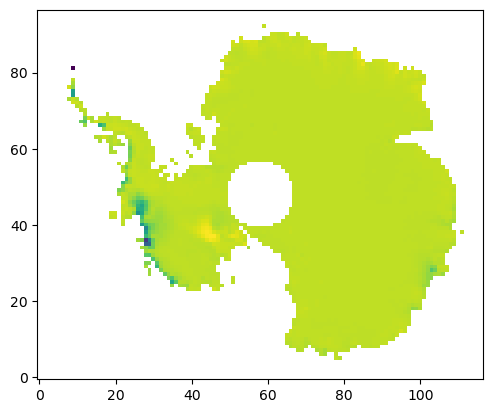

In [122]:
plt.imshow(container, origin = "lower")

In [124]:
merged.to_csv("data/merged.csv", index = False)

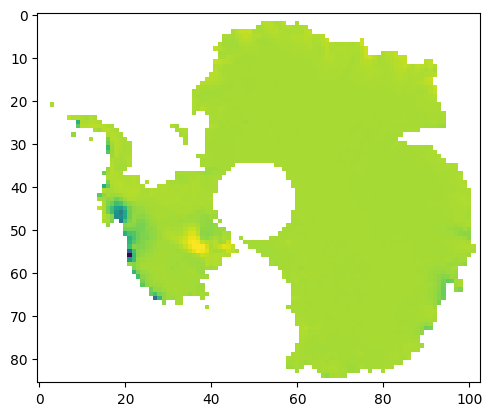

In [128]:
pool = torch.nn.AvgPool2d(kernel_size = 10, stride = 10, padding = 0)
# goes from 863, 1035 -> 86, 103
pooled = pool(torch.tensor(dm.mwe.values)).squeeze(0)
plt.imshow(pooled)

In [134]:
xx, yy = np.meshgrid(dm.mwe.x.values, dm.mwe.y.values)

In [148]:
xx_pooled = pool(torch.tensor(xx).unsqueeze(0)) # middle only 1000 meters off :)
xx_pooled[0, 0, 0] -(-2500000)

yy_pooled = pool(torch.tensor(yy).unsqueeze(0))
yy_pooled[0, :, 0] # 2160033.9856

tensor([ 2160033.9856,  2110033.9856,  2060033.9856,  2010033.9856,
         1960033.9856,  1910033.9856,  1860033.9856,  1810033.9856,
         1760033.9856,  1710033.9856,  1660033.9856,  1610033.9856,
         1560033.9856,  1510033.9856,  1460033.9856,  1410033.9856,
         1360033.9856,  1310033.9856,  1260033.9856,  1210033.9856,
         1160033.9856,  1110033.9856,  1060033.9856,  1010033.9856,
          960033.9856,   910033.9856,   860033.9856,   810033.9856,
          760033.9856,   710033.9856,   660033.9856,   610033.9856,
          560033.9856,   510033.9856,   460033.9856,   410033.9856,
          360033.9856,   310033.9856,   260033.9856,   210033.9856,
          160033.9856,   110033.9856,    60033.9856,    10033.9856,
          -39966.0144,   -89966.0144,  -139966.0144,  -189966.0144,
         -239966.0144,  -289966.0144,  -339966.0144,  -389966.0144,
         -439966.0144,  -489966.0144,  -539966.0144,  -589966.0144,
         -639966.0144,  -689966.0144,  -739966.0

In [130]:
np.nanmin(pooled)
np.nanmax(pooled)

0.4551917

In [79]:
dm.mwe

<xarray.DataArray 'mwe' (band: 1, y: 863, x: 1035)> Size: 4MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 8kB -2.524e+06 -2.519e+06 ... 2.641e+06 2.646e+06
  * y            (y) float64 7kB 2.183e+06 2.178e+06 ... -2.122e+06 -2.127e+06
    spatial_ref  int64 8B 0
    mwe          (band, y, x) float32 4MB nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: band

In [93]:
print(np.nanmax(dm.values))
print(np.nanmin(dm.values))

1.0233387
-27.988829


In [117]:
print(np.nanmax(dm.mwe.values))
print(np.nanmin(dm.mwe.values))
print(np.nansum(dm.mwe.values))

0.9381969
-25.660158
-4665.8037


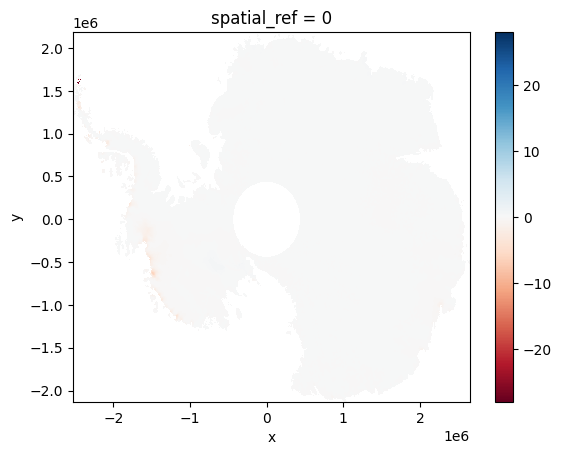

In [94]:
dm.plot(cmap = 'RdBu')

### Check spatial resolution

In [31]:
dm.x[0] - dm.x[1]
dm.y[0] - dm.y[1]

<xarray.DataArray 'y' ()> Size: 8B
array(5000.)
Coordinates:
    spatial_ref  int64 8B 0

# X 16 for 16 years

- common unit (ice or water?)
- isotopic: same areas of observation

- need something more smoothing
- write my owne function for nan pooling. mean nan for all values in the area.

In [ ]:
# smooth with 50 x 50 convolution

In [106]:
psp_x = np.array(torch.arange(-2900000., 2900000.+1, 50000))
psp_y = np.array(torch.arange(-2400000., 2400000.+1, 50000))

# 2D linear interpolation: only uses the 4 nearest points, we can use this for 50km grid (too locatised)
icesat_50km = dm.interp(x = psp_x, y = psp_y, method = "linear")
# icesat_50km = dm.interp(x = psp_x, y = psp_y, method = "cubic") # does not work

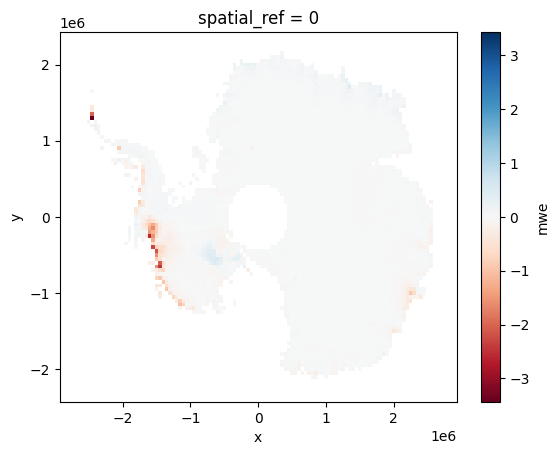

In [107]:
icesat_50km.mwe.plot(cmap = 'RdBu')

In [104]:
print(np.nanmax(icesat_50km.mwe.values))
print(np.nanmin(icesat_50km.mwe.values))

nan
nan


/tmp/ipykernel_241094/3813827996.py:1: RuntimeWarning:

All-NaN slice encountered

/tmp/ipykernel_241094/3813827996.py:2: RuntimeWarning:

All-NaN slice encountered



In [113]:
icesat_50km.mwe.values.squeeze()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [116]:
fig = go.Figure(go.Heatmap(
    # mean or sum
    z = icesat_50km.mwe.values.squeeze(),
    colorscale = 'RdBu',
    zmid = 0,
    ))

fig.update_layout(
    title = "Mean mass balance change over all months",
)

fig.update_traces(colorbar_orientation = "v")
fig.update_traces(colorbar_title = "meters w.e.")
fig.update_traces(colorbar_len = 0.7)

fig.update_layout(
    height = 800,
    width = 800,
    yaxis_scaleanchor = "x",
)

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")
# fig.update_layout(font_family = "Open Sans")

fig.show()